<a href="https://colab.research.google.com/github/NikkiShah93/Python/blob/main/MLProjects/PyTorchProjects/DeepLearning/neural_network_classification_pytorch_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classification with PyTorch

The steps we will go through are as follows:
- Making the notebook device agnostic
- Creating random data for our model
- Data exploration and visualization
- Formatting the data for train and test sets
- Creating our Classification Model
  - Training loop
  - Testing loop
  - Visualizing the loss curve

In [1]:
## first the imports
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
## we will be using sklearn to get data splitting
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
torch.__version__

'2.2.1+cu121'

In [2]:
## making our notebook device agnostic
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
## using the make circle for our sample generation
n_samples = 1000
random_seed = 0
X, y = make_circles(n_samples=n_samples,
                    noise=3e-2,
                    random_state=random_seed)
X[:5], y[:5]

(array([[ 0.80993549, -0.053514  ],
        [-0.13448628, -0.74209474],
        [-0.81250606, -0.62424399],
        [ 0.5830736 ,  0.49656776],
        [-0.46132008,  0.65983601]]),
 array([1, 1, 0, 1, 1]))

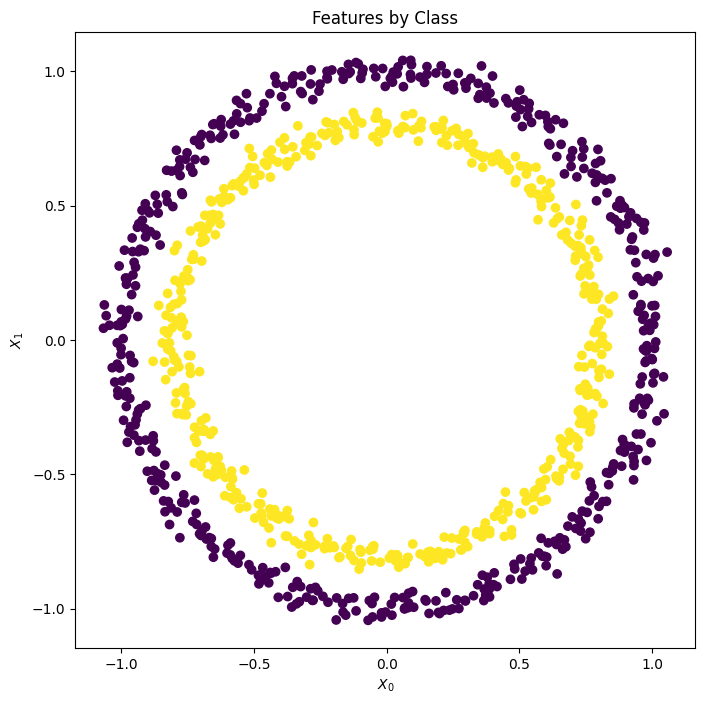

In [4]:
## some data exploration
plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:, 1], c=y)
plt.xlabel('$X_0$')
plt.ylabel('$X_1$')
plt.title('Features by Class');

In [5]:
## since our data is already in numerical format
## we don't need to do any real pre-processing
## but we still need to create tensors, adjust dtype, move them to device, and split them
X_tensor = torch.from_numpy(X).type(torch.float32).to(device)
y_tensor = torch.from_numpy(y).type(torch.float32).to(device)
print(X_tensor[:5],'\n', y_tensor[:5])
X_train, X_test = torch.split(X_tensor, [int(.8*X_tensor.shape[0]), int(.2*X_tensor.shape[0])])
y_train, y_test = torch.split(y_tensor, [int(.8*y_tensor.shape[0]), int(.2*y_tensor.shape[0])])
len(X_train), len(y_train), len(X_test), len(y_test)

tensor([[ 0.8099, -0.0535],
        [-0.1345, -0.7421],
        [-0.8125, -0.6242],
        [ 0.5831,  0.4966],
        [-0.4613,  0.6598]]) 
 tensor([1., 1., 0., 1., 1.])


(800, 800, 200, 200)

In [6]:
## next we have to start with our model
class BinaryClassification(nn.Module):
  def __init__(self, in_feature, hidden_layer, out_shape):
    super(BinaryClassification, self).__init__()
    self.l1 = nn.Linear(in_features=in_feature,
                        out_features=hidden_layer)
    self.l2 = nn.Linear(in_features=hidden_layer,
                        out_features=out_shape)
    self.relu = nn.ReLU()
    self.sig = nn.Sigmoid()

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    out = self.l1(x)
    out = self.relu(out)
    out = self.l2(out)
    return self.sig(out).squeeze()
hidden_layer = int(8 * X_train.shape[1])
## creating an instance
model = BinaryClassification(in_feature=X_train.shape[1],
                             hidden_layer =hidden_layer,
                             out_shape = 1)
model = model.to(device)
## starting with the loss function
## which will be BCE
loss = nn.BCELoss()
## and for our optimizer
## we'll be using Adam
learning_rate = 1e-2
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr = learning_rate)
## dict for storing the loss
info_dict = {}
## starting with the training loop
epochs = 500
for e in range(epochs):
  model.train()
  yhat = model(X_train)
  ## calculating the loss
  l = loss(yhat, y_train)
  ## zeroing the grad
  optimizer.zero_grad()
  ## then backward
  l.backward()
  ## taking a step
  optimizer.step()
  if e%10==0:
    info_dict[e] = l.item()
    model.eval()
    with torch.inference_mode():
      ypred = model(X_test)
      l_t = loss(ypred,y_test)
      if e%50==0:
        print(f'Epoch {e} \ntrain loss is: {round(l.item(), 2)}')
        print(f'test loss:{round(l_t.item(), 2)}\n')


Epoch 0 
train loss is: 0.69
test loss:0.69

Epoch 50 
train loss is: 0.61
test loss:0.61

Epoch 100 
train loss is: 0.44
test loss:0.44

Epoch 150 
train loss is: 0.26
test loss:0.27

Epoch 200 
train loss is: 0.15
test loss:0.16

Epoch 250 
train loss is: 0.1
test loss:0.11

Epoch 300 
train loss is: 0.07
test loss:0.08

Epoch 350 
train loss is: 0.05
test loss:0.06

Epoch 400 
train loss is: 0.04
test loss:0.05

Epoch 450 
train loss is: 0.03
test loss:0.04



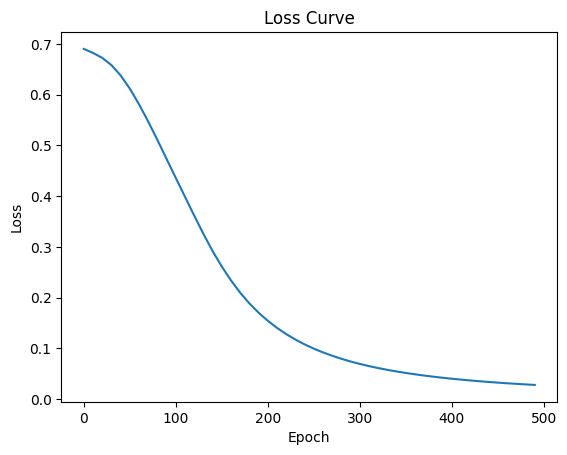

In [7]:
plt.plot(*zip(*info_dict.items()))
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss');

The second model

In [8]:
## Binary classification with nn.sequantial
## and BCE with Logit
class BinaryClassificationSeq(nn.Module):
  def __init__(self, in_features, hidden_layer, out_features):
    super().__init__()
    self.seq = nn.Sequential(

            nn.Linear(in_features=in_features,
                      out_features=hidden_layer),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layer,
            out_features=hidden_layer),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layer,
            out_features=out_features),
            # nn.Sigmoid() ## using the BCE + Logit => which is more stable
    )

  def forward(self, x):
    return self.seq(x)
## loss dict
loss_dict = {}
learning_rate = 1e-3
epochs = 1000
model_1 = BinaryClassificationSeq(in_features=X_train.shape[1],
                                  out_features=1,
                                  hidden_layer=8)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                            lr=learning_rate)
## and then finally the training loop
for e in range(epochs):
  ## calculating the predictions
  ypred = model_1(X_train).squeeze()
  ## calculating the loss
  l = loss_fn(ypred, y_train)
  optimizer.zero_grad()
  l.backward()
  optimizer.step()
  if e%50==0:
    loss_dict[e] = l.item()
    model.eval()
    with torch.inference_mode():
      yhat = model_1(X_test).squeeze()
      lt = loss_fn(yhat, y_test)
    print(f'Epoch:{e}, train loss:{round(l.item(), 2)}, test loss:{round(lt.item(), 2)}')

Epoch:0, train loss:0.7, test loss:0.7
Epoch:50, train loss:0.69, test loss:0.69
Epoch:100, train loss:0.68, test loss:0.69
Epoch:150, train loss:0.68, test loss:0.68
Epoch:200, train loss:0.66, test loss:0.66
Epoch:250, train loss:0.64, test loss:0.64
Epoch:300, train loss:0.6, test loss:0.6
Epoch:350, train loss:0.54, test loss:0.54
Epoch:400, train loss:0.46, test loss:0.47
Epoch:450, train loss:0.39, test loss:0.39
Epoch:500, train loss:0.32, test loss:0.33
Epoch:550, train loss:0.26, test loss:0.27
Epoch:600, train loss:0.21, test loss:0.21
Epoch:650, train loss:0.16, test loss:0.17
Epoch:700, train loss:0.13, test loss:0.14
Epoch:750, train loss:0.11, test loss:0.11
Epoch:800, train loss:0.09, test loss:0.09
Epoch:850, train loss:0.07, test loss:0.08
Epoch:900, train loss:0.06, test loss:0.07
Epoch:950, train loss:0.05, test loss:0.06


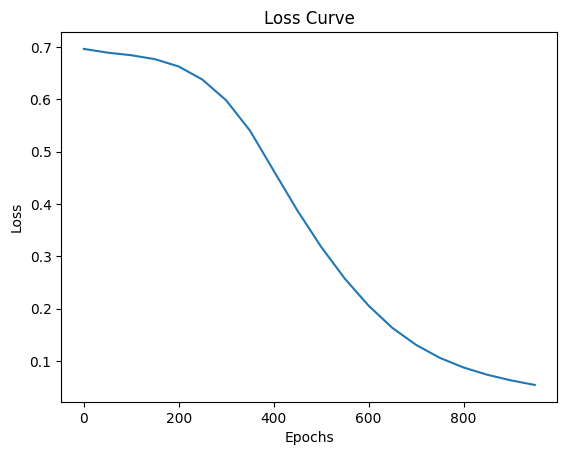

In [9]:
plt.plot(*zip(*loss_dict.items()))
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss');

### Multi-Class Classification


In [10]:
## using the make_blobs for this round
from sklearn.datasets import make_blobs
n_samples = 1000
X, y = make_blobs(n_samples=n_samples,
                  n_features=3,
                  centers= 4,
                  cluster_std=1)
X.shape, y.shape, X[:5], y[:5]

((1000, 3),
 (1000,),
 array([[-3.68827196,  4.44290179, -0.81606712],
        [-3.99761642,  4.8655869 , -0.30332377],
        [-4.92817084, -4.70839585, -6.64373946],
        [-4.59593342, -4.42101263, -7.33825621],
        [-3.69376893, -2.7989435 , -5.23781447]]),
 array([2, 2, 1, 1, 1]))

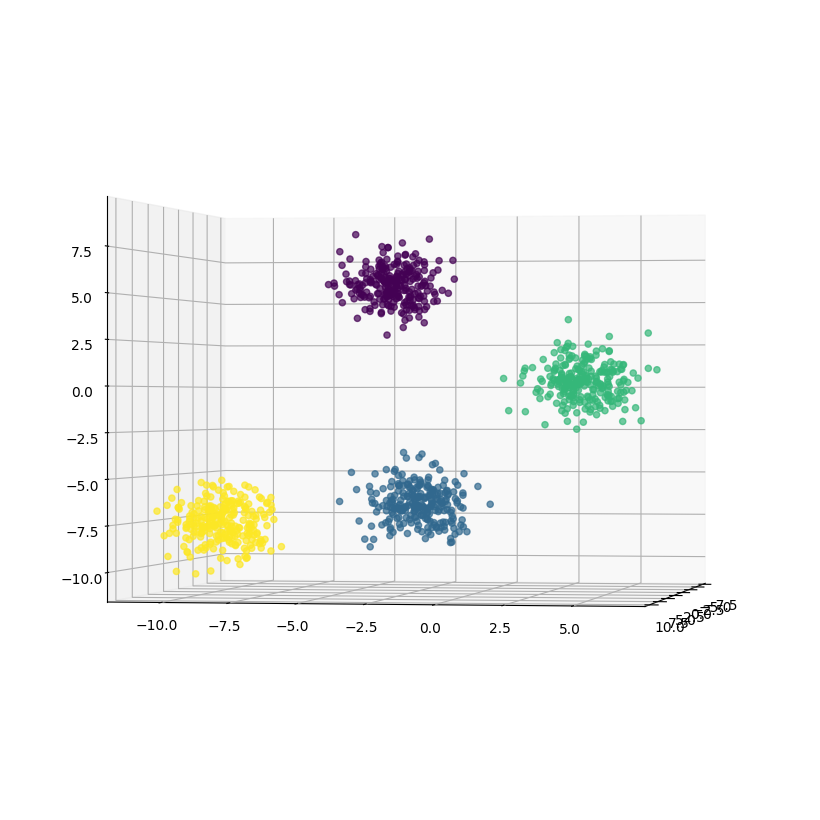

In [11]:
## visualizing the data
fig = plt.figure(figsize= (8, 8))
ax = fig.add_axes([1,1,1,1],projection='3d')
ax.scatter3D(X[:,0], X[:,1], X[:,2], c=y,
            alpha=.7)
ax.view_init(0,10);

In [12]:
## creating our train and test samples
split_ind = int(.8*X.shape[0])
X_train, X_test = np.split(X, [split_ind])
y_train, y_test = np.split(y, [split_ind])

## and then converting them into tensors
## and moving them to device
X_train, X_test = torch.from_numpy(X_train).type(torch.float).to(device), torch.from_numpy(X_test).type(torch.float).to(device)
y_train, y_test = torch.from_numpy(y_train).type(torch.float).to(device), torch.from_numpy(y_test).type(torch.float).to(device)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 3]),
 torch.Size([200, 3]),
 torch.Size([800]),
 torch.Size([200]))

In [28]:
## next step is to create our model
class MClassClassifier(nn.Module):
  def __init__(self, in_feature, hidden_layer, out_feature):
    super().__init__()
    self.l1 = nn.Linear(in_features=in_feature,
                        out_features = hidden_layer)

    self.l2 = nn.Linear(in_features=hidden_layer,
                        out_features = hidden_layer)

    self.l3 = nn.Linear(in_features=hidden_layer,
                        out_features = out_feature)
    self.relu = nn.ReLU()
    self.softm = nn.Softmax(dim=1)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    out = self.l1(x)
    out = self.relu(out)
    out = self.l2(out)
    out = self.relu(out)
    out = self.l3(out)
    # return self.softm(out)
    return out

## creating our instance
model = MClassClassifier(in_feature = X_train.shape[1],
                          # hidden_layer=8**(int(X_train.shape[1])), ## this was too slow
                         hidden_layer=8*(int(X_train.shape[1])),
                          out_feature = y_train.unique().shape[0]).to(device)
## loss and optimizer
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = learning_rate)
## staring with the training loop
epochs = 150
loss_dict = {}
for e in range(epochs):
  model.train()
  ypred = model(X_train)
  l = loss_fn(ypred, y_train.type(torch.long))
  optimizer.zero_grad()
  l.backward()
  optimizer.step()
  if e%10==0:
    loss_dict[e]= l.item()
    model.eval()
    with torch.inference_mode():
      yhat = model(X_test)
      lt = loss_fn(yhat, y_test.type(torch.long))
      print(f'Epoch:{e}, train loss:{l:.2f}, test loss:{lt:.2f}')
test_acc = ((torch.softmax(yhat, dim=1).argmax(dim=1) == y_test).sum()/len(y_test)) * 100
train_acc = ((torch.softmax(ypred, dim=1).argmax(dim=1) == y_train).sum()/len(y_train)) * 100
print(f'The final accuracy of the model: \nTrain {train_acc:.2f}% | Test: {test_acc:.2f}% ')

Epoch:0, train loss:1.44, test loss:1.39
Epoch:10, train loss:1.08, test loss:1.04
Epoch:20, train loss:0.80, test loss:0.77
Epoch:30, train loss:0.58, test loss:0.56
Epoch:40, train loss:0.41, test loss:0.39
Epoch:50, train loss:0.28, test loss:0.26
Epoch:60, train loss:0.18, test loss:0.18
Epoch:70, train loss:0.12, test loss:0.12
Epoch:80, train loss:0.08, test loss:0.08
Epoch:90, train loss:0.06, test loss:0.06
Epoch:100, train loss:0.05, test loss:0.05
Epoch:110, train loss:0.04, test loss:0.04
Epoch:120, train loss:0.03, test loss:0.03
Epoch:130, train loss:0.02, test loss:0.03
Epoch:140, train loss:0.02, test loss:0.02
The final accuracy of the model: 
Train 100.00% | Test: 100.00% 


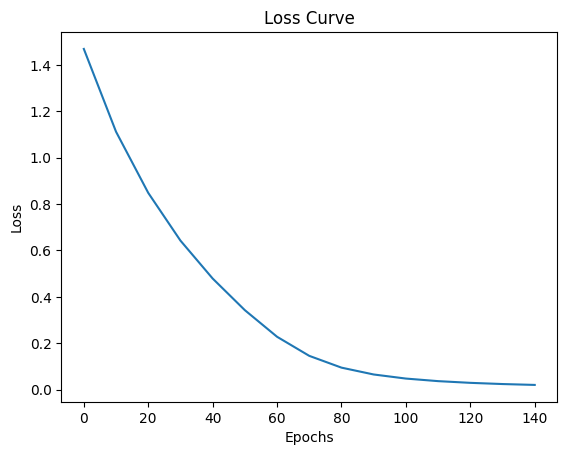

In [26]:
plt.plot(*zip(*loss_dict.items()))
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss');

In [15]:
## we will be using some data from UCI for as our sample
## which is for spam/not spam classification
data = pd.read_csv('https://archive.ics.uci.edu/static/public/94/data.csv')
data.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,Class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [16]:
def relu(x):
  # activated = torch.tensor([max(0, v) for v in x], dtype= torch.float)
  activated = torch.max(torch.tensor(0), x)
  return activated

random_data = np.linspace(-5, 5, 100)
activated_data = relu(torch.from_numpy(random_data).type(torch.float))
activated_data

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0505, 0.1515, 0.2525, 0.3535,
        0.4545, 0.5556, 0.6566, 0.7576, 0.8586, 0.9596, 1.0606, 1.1616, 1.2626,
        1.3636, 1.4646, 1.5657, 1.6667, 1.7677, 1.8687, 1.9697, 2.0707, 2.1717,
        2.2727, 2.3737, 2.4747, 2.5758, 2.6768, 2.7778, 2.8788, 2.9798, 3.0808,
        3.1818, 3.2828, 3.3838, 3.4848, 3.5859, 3.6869, 3.7879, 3.8889, 3.9899,
        4.0909, 4.1919, 4.2929, 4.3939, 4.4949, 4.5960, 4.6970, 4.7980, 4.8990,
        5.0000])

In [17]:
def sig(x):
  return 1 / 1+ torch.exp(-x)

c = torch.linspace(0, 1, 100)

print(c[:5])
print(sig(c)[:5])

tensor([0.0000, 0.0101, 0.0202, 0.0303, 0.0404])
tensor([2.0000, 1.9899, 1.9800, 1.9702, 1.9604])


In [18]:
y_train

tensor([2., 2., 1., 1., 1., 3., 2., 2., 0., 0., 1., 0., 1., 1., 1., 0., 3., 1.,
        0., 2., 0., 3., 1., 2., 2., 1., 0., 2., 1., 2., 2., 3., 1., 1., 0., 1.,
        3., 3., 3., 1., 1., 1., 1., 2., 1., 2., 3., 0., 0., 2., 2., 2., 0., 1.,
        3., 3., 3., 0., 2., 3., 3., 3., 3., 3., 0., 0., 2., 1., 1., 1., 1., 0.,
        2., 1., 3., 2., 0., 2., 3., 3., 1., 3., 3., 1., 2., 2., 1., 2., 3., 0.,
        3., 3., 0., 3., 1., 2., 3., 0., 3., 0., 1., 0., 1., 2., 3., 3., 1., 1.,
        3., 3., 1., 1., 1., 0., 2., 2., 2., 0., 2., 1., 0., 0., 1., 3., 1., 1.,
        2., 1., 2., 3., 1., 2., 1., 0., 0., 0., 2., 0., 0., 2., 3., 2., 3., 3.,
        0., 1., 0., 1., 2., 2., 3., 0., 3., 2., 0., 1., 0., 0., 2., 0., 0., 1.,
        0., 0., 3., 0., 1., 2., 3., 0., 1., 3., 1., 2., 0., 1., 3., 3., 2., 1.,
        3., 3., 0., 0., 2., 1., 3., 1., 0., 3., 0., 2., 2., 0., 1., 0., 2., 1.,
        3., 1., 0., 0., 3., 1., 3., 3., 1., 3., 3., 0., 0., 2., 2., 2., 3., 2.,
        2., 1., 2., 0., 3., 2., 1., 3., 